# MNIST Image Classification Implementation (using linear layers)

## Purpose

The purpose of this notebook is to create a model (using linear layers) that can, with high accuracy (~96%), classify the handwritten digits in the MNIST dataset. This notebook also allowed me to use PyTorch's image transformations and various other helper functions.

## Imports

In [0]:
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import PIL.ImageOps
from torch import nn
from torchvision import datasets, transforms
from tqdm import tqdm

## Preprocessing the image data from MNIST

Transformations used:

- ToTensor will convert the 28x28 numpy array with pixel brightness values ranging from 0-255 (which is the structure the images in the MNIST dataset are currently in) to a float tensor with pixel brightness values ranging from 0-1

- Normalize will apply normalization to the pixel brightness values (subtract value from mean and then divide by the standard deviation). This makes convergence to minumum loss quicker. 



In [0]:
transform = transforms.Compose([
                               transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ]) # defining the transformations we want to make to the images before feeding them into our model
                                                          
training_dataset = datasets.MNIST(root = './data', train=True, download=True, transform=transform) 
validation_dataset = datasets.MNIST(root = './data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle=True) # create a dataloader to handle batching of the data. Note that we shuffle the data at each epoch to prevent the gradient descent process from getting stuck in a local minimum, we want it to reach the absolute minimum.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

## Plotting the original training images

In [0]:
def image_convert(tensor): # all this function does is prepeare the images for plotting by changing them from tensors to numpy arrays and also reversing the transforms made when creating the training_dataset
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

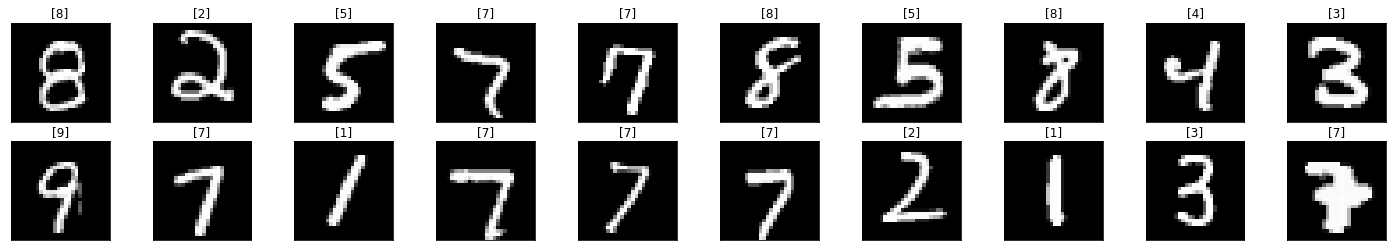

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  axis = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(image_convert(images[idx]))
  axis.set_title([labels[idx].item()])
  

## Building the model

In [0]:
class Classifier(nn.Module):
  def __init__(self, n_input_nodes, H1, H2, num_output_nodes):
    super().__init__()
    self.linear1 = nn.Linear(n_input_nodes, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, num_output_nodes)
  
  def forward(self, x):
    x = F.relu(self.linear1(x)) # we use relu as our activation function throughout the feed-forward process
    x = F.relu(self.linear2(x))
    x = self.linear3(x) # note that we don't apply an activation function at the last layer in this forward function as it is implicitly applied later in the nn.CrossEntropyLoss function
    return x  

In [0]:
model = Classifier(784, 125, 65, 10) # 784 nodes in the input layer since each image is 28x28 pixels, the 125 and 65 nodes in the hidden layers is chosen arbitrarily (it turns out these values yield good results in the end), finally the 10 nodes in the output layer is chosen since there are 10 potential outputs (the values 0-9)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss() # we use Cross Entropy Loss for the loss function since it is a multi-class problem. Remember that this function also implicitly applies the log_softmax activation function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # We use Adam as our optimizer

## Training the model

In [0]:
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

def train():
  for e in tqdm(range(epochs)):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
      inputs = inputs.view(inputs.shape[0], -1) # We must reshape the image inputs so they can be fed forward throughout the model
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, 1) # gets the prediction of the model
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data) # counts the number of images classified correctly by comparing the prediction to the corresponding label

    else: # this block of code is executed after all of the iterations (end of an epoch)
      with torch.no_grad(): # this will set requires_grad = False for the tensors since no gradients need to be taken in this step. This is done to save memory. 
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.view(val_inputs.shape[0], -1) # We must reshape the image inputs so they can be fed forward throughout the model
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1) # gets the prediction of the model
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data) # counts the number of images classified correctly by comparing the prediction to the corresponding label
        
      epoch_loss = running_loss/len(training_loader) # average loss for each epoch
      epoch_accuracy = running_corrects.float()/len(training_loader) # accuracy for each epoch
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_accuracy)
      
      val_epoch_loss = val_running_loss/len(validation_loader) # average loss for each epoch
      val_epoch_accuracy = val_running_corrects.float()/len(validation_loader) # accuracy for each epoch
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_accuracy)
      
      print("")
      print("Epoch #{}".format(e+1))
      print("Training loss: {:.4f}, Training Accuracy: {:.4f}".format(epoch_loss, epoch_accuracy.item()))
      print("Validation loss: {:.4f}, Validation Accuracy: {:.4f}".format(val_epoch_loss, val_epoch_accuracy.item()))

    

In [0]:
train()


  8%|▊         | 1/12 [00:16<03:00, 16.44s/it]


Epoch #1
Training loss: 0.3961, Training Accuracy: 87.4067
Validation loss: 0.2657, Validation Accuracy: 91.4400



 17%|█▋        | 2/12 [00:36<02:54, 17.48s/it]


Epoch #2
Training loss: 0.2351, Training Accuracy: 92.9800
Validation loss: 0.2119, Validation Accuracy: 93.6800



 25%|██▌       | 3/12 [00:55<02:42, 18.09s/it]


Epoch #3
Training loss: 0.2180, Training Accuracy: 93.5267
Validation loss: 0.2265, Validation Accuracy: 93.3300



 33%|███▎      | 4/12 [01:15<02:28, 18.53s/it]


Epoch #4
Training loss: 0.2001, Training Accuracy: 94.1050
Validation loss: 0.2112, Validation Accuracy: 93.6400



 42%|████▏     | 5/12 [01:34<02:11, 18.84s/it]


Epoch #5
Training loss: 0.1876, Training Accuracy: 94.4667
Validation loss: 0.2032, Validation Accuracy: 93.7000



 50%|█████     | 6/12 [01:54<01:54, 19.06s/it]


Epoch #6
Training loss: 0.1909, Training Accuracy: 94.4583
Validation loss: 0.1952, Validation Accuracy: 94.5100



 58%|█████▊    | 7/12 [02:14<01:36, 19.28s/it]


Epoch #7
Training loss: 0.1786, Training Accuracy: 94.8000
Validation loss: 0.2466, Validation Accuracy: 93.1100



 67%|██████▋   | 8/12 [02:33<01:17, 19.38s/it]


Epoch #8
Training loss: 0.1866, Training Accuracy: 94.7200
Validation loss: 0.2182, Validation Accuracy: 94.0200



 75%|███████▌  | 9/12 [02:53<00:58, 19.47s/it]


Epoch #9
Training loss: 0.1763, Training Accuracy: 94.9533
Validation loss: 0.2014, Validation Accuracy: 94.7500



 83%|████████▎ | 10/12 [03:13<00:39, 19.54s/it]


Epoch #10
Training loss: 0.1772, Training Accuracy: 94.9650
Validation loss: 0.2145, Validation Accuracy: 94.3000



 92%|█████████▏| 11/12 [03:33<00:19, 19.60s/it]


Epoch #11
Training loss: 0.1766, Training Accuracy: 95.0533
Validation loss: 0.2243, Validation Accuracy: 94.0000



100%|██████████| 12/12 [03:52<00:00, 19.60s/it]



Epoch #12
Training loss: 0.1774, Training Accuracy: 95.0467
Validation loss: 0.2339, Validation Accuracy: 94.0600


## Plotting the results

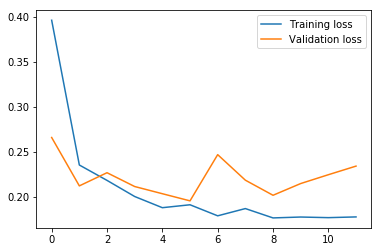

In [0]:
plt.plot(running_loss_history, label="Training loss")
plt.plot(val_running_loss_history, label="Validation loss")
plt.legend()

## Retraining the model (tuning hyper-parameters)

We notice that the loss graph is fluctuating too much, which leads me to believe the learning rate is too high as the steps it is taking are too drastic. Therefore we will decrease the learning rate, reinitialize the model, and then retrain the model. I also increased the number of epochs as it does not appear that it has reached its asymptote.

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

model = Classifier(784, 125, 65, 10)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
train()


  7%|▋         | 1/15 [00:16<03:49, 16.38s/it]


Epoch #1
Training loss: 0.9442, Training Accuracy: 77.4217
Validation loss: 0.4208, Validation Accuracy: 89.1700



 13%|█▎        | 2/15 [00:32<03:33, 16.45s/it]


Epoch #2
Training loss: 0.3758, Training Accuracy: 89.4183
Validation loss: 0.3230, Validation Accuracy: 91.0000



 20%|██        | 3/15 [00:49<03:17, 16.44s/it]


Epoch #3
Training loss: 0.3163, Training Accuracy: 90.9267
Validation loss: 0.2902, Validation Accuracy: 91.6600



 27%|██▋       | 4/15 [01:05<03:01, 16.47s/it]


Epoch #4
Training loss: 0.2846, Training Accuracy: 91.8333
Validation loss: 0.2638, Validation Accuracy: 92.3600



 33%|███▎      | 5/15 [01:22<02:44, 16.49s/it]


Epoch #5
Training loss: 0.2617, Training Accuracy: 92.4817
Validation loss: 0.2500, Validation Accuracy: 92.9300



 40%|████      | 6/15 [01:39<02:28, 16.53s/it]


Epoch #6
Training loss: 0.2410, Training Accuracy: 93.0883
Validation loss: 0.2295, Validation Accuracy: 93.4500



 47%|████▋     | 7/15 [01:55<02:12, 16.54s/it]


Epoch #7
Training loss: 0.2232, Training Accuracy: 93.6083
Validation loss: 0.2144, Validation Accuracy: 93.6800



 53%|█████▎    | 8/15 [02:12<01:56, 16.59s/it]


Epoch #8
Training loss: 0.2073, Training Accuracy: 94.0350
Validation loss: 0.1948, Validation Accuracy: 94.2600



 60%|██████    | 9/15 [02:29<01:39, 16.62s/it]


Epoch #9
Training loss: 0.1924, Training Accuracy: 94.5050
Validation loss: 0.1864, Validation Accuracy: 94.5300



 67%|██████▋   | 10/15 [02:46<01:23, 16.71s/it]


Epoch #10
Training loss: 0.1794, Training Accuracy: 94.8717
Validation loss: 0.1730, Validation Accuracy: 94.8500



 73%|███████▎  | 11/15 [03:02<01:06, 16.64s/it]


Epoch #11
Training loss: 0.1674, Training Accuracy: 95.2000
Validation loss: 0.1676, Validation Accuracy: 95.1700



 80%|████████  | 12/15 [03:19<00:49, 16.65s/it]


Epoch #12
Training loss: 0.1563, Training Accuracy: 95.5700
Validation loss: 0.1571, Validation Accuracy: 95.4000



 87%|████████▋ | 13/15 [03:35<00:33, 16.62s/it]


Epoch #13
Training loss: 0.1477, Training Accuracy: 95.7600
Validation loss: 0.1455, Validation Accuracy: 95.6900



 93%|█████████▎| 14/15 [03:52<00:16, 16.60s/it]


Epoch #14
Training loss: 0.1395, Training Accuracy: 95.9983
Validation loss: 0.1387, Validation Accuracy: 95.9700



100%|██████████| 15/15 [04:08<00:00, 16.59s/it]



Epoch #15
Training loss: 0.1315, Training Accuracy: 96.2083
Validation loss: 0.1334, Validation Accuracy: 95.9800


## Plotting the new results

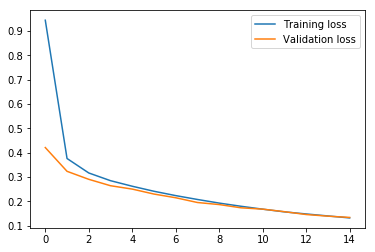

In [0]:
plt.plot(running_loss_history, label="Training loss")
plt.plot(val_running_loss_history, label="Validation loss")
plt.legend()

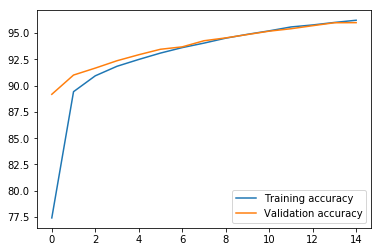

In [0]:
plt.plot(running_corrects_history, label ="Training accuracy")
plt.plot(val_running_corrects_history, label ="Validation accuracy")
plt.legend()

## Final Testing

We will further test the model by grabbing an image of the number '5' from the web, and see how well our model predicts that it's a '5'.

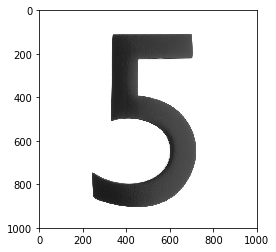

In [0]:
import requests
from PIL import Image

url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)

plt.imshow(img)

We must apply some preprocessing to this image so that it can be classified by our model:

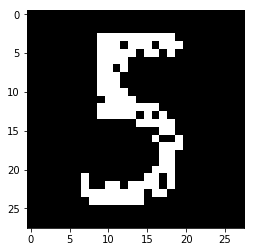

In [0]:
img = PIL.ImageOps.invert(img) # inverts the colours of the image
img = img.convert('1') # converts image to black and white instead of RGB
img = transform(img)
plt.imshow(image_convert(img)) # we have to convert the image back to a numpy array for plt.imshow to render the image

In [0]:
img = img.view(img.shape[0], -1) # We must reshape the image inputs so they can be fed forward throughout the model
output = model(img)
_, pred = torch.max(output, 1) # gets the prediction of the model
print("Prediction is: {}".format(pred.item()))

Prediction is: 5


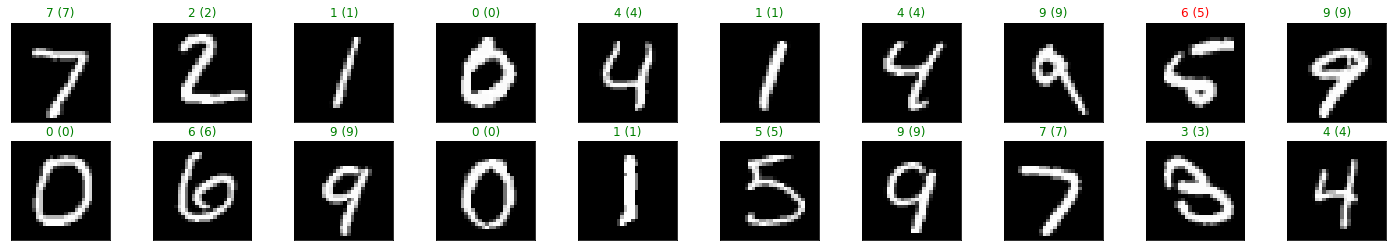

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))